In [27]:
from phi.flow import *

In [28]:
N = 128 
STEPS = 32 
DT = 1./STEPS 
NU = 0.01/np.pi

In [29]:
# initialization of velocities 
INITIAL_NUMPY = np.asarray( [-np.sin(np.pi * x) * 1. for x in np.linspace(-1,1,N)] ) # 1D numpy ˓→array 
INITIAL = math.tensor(INITIAL_NUMPY, spatial('x') ) # convert to phiflow tensor

In [30]:
#velocity = CenteredGrid(INITIAL, extrapolation.PERIODIC, x=N, bounds=Box[-1:1]) 
velocity = CenteredGrid(Noise(), extrapolation.PERIODIC, x=N, bounds=Box[-1:1]) # random init
print("Velocity tensor shape: " + format( velocity.shape )) # == velocity.values.shape 
print("Velocity tensor type: " + format( type(velocity.values) )) 
print("Velocity tensor entries 10 to 14: " + format( velocity.values.numpy()[10:15] ))

Velocity tensor shape: (xˢ=128)
Velocity tensor type: <class 'phi.math._tensors.NativeTensor'>
Velocity tensor entries 10 to 14: [1.7245195  1.5657148  1.3500152  1.0857495  0.83252186]


In [31]:
velocities = [velocity] 
age = 0. 
for i in range(STEPS): 
    v1 = diffuse.explicit(velocities[-1], NU, DT)
    v2 = advect.semi_lagrangian(v1, v1, DT) 
    age += DT 
    velocities.append(v2)
    print("New velocity content at t={}: {}".format( age, velocities[-1].values.numpy()[0:5] ))

New velocity content at t=0.03125: [1.5857191 1.7670476 1.9287812 2.0570335 2.1622915]
New velocity content at t=0.0625: [1.0767068 1.1709783 1.2774162 1.4010334 1.5320159]
New velocity content at t=0.09375: [0.89221054 0.96142006 1.0290275  1.0954151  1.1650022 ]
New velocity content at t=0.125: [0.7743951  0.8286397  0.88821393 0.94820195 1.0067035 ]
New velocity content at t=0.15625: [0.6937822  0.74038273 0.7865424  0.8348431  0.8874195 ]
New velocity content at t=0.1875: [0.62647605 0.67066216 0.7136688  0.75563014 0.7974342 ]
New velocity content at t=0.21875: [0.56958747 0.61103487 0.65177333 0.69167423 0.73066336]
New velocity content at t=0.25: [0.5215844  0.56024295 0.59844977 0.63615185 0.67326164]
New velocity content at t=0.28125: [0.48077628 0.51687104 0.5526285  0.58804303 0.62308395]
New velocity content at t=0.3125: [0.44573656 0.47954464 0.51306987 0.54633003 0.57932293]
New velocity content at t=0.34375: [0.41739845 0.447132   0.47865954 0.5099619  0.54105186]
New ve

In [32]:
# get "velocity.values" from each phiflow state with a channel dimensions, i.e. "vector" 
vels = [v.values.numpy('x,vector') for v in velocities] # gives a list of 2D arrays

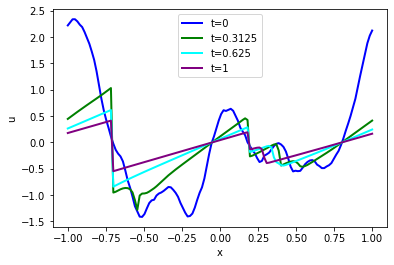

In [33]:
import pylab

fig = pylab.figure().gca() 
fig.plot(np.linspace(-1,1,len(vels[ 0].flatten())), vels[ 0].flatten(), lw=2, color='blue', label= "t=0")
fig.plot(np.linspace(-1,1,len(vels[10].flatten())), vels[10].flatten(), lw=2, color='green', label= "t=0.3125")
fig.plot(np.linspace(-1,1,len(vels[20].flatten())), vels[20].flatten(), lw=2, color='cyan', label= "t=0.625")
fig.plot(np.linspace(-1,1,len(vels[32].flatten())), vels[32].flatten(), lw=2, color='purple',label= "t=1")
pylab.xlabel('x'); pylab.ylabel('u'); pylab.legend()

In [34]:
def show_state(a, title): 
    # we only have 33 time steps, blow up by a factor of 2^4 to make it easier to see 
    # (could also be done with more evaluations of network) 
    a=np.expand_dims(a, axis=2) 
    for i in range(4): 
        a = np.concatenate( [a,a] , axis=2)
    a = np.reshape( a, [a.shape[0],a.shape[1]*a.shape[2]] )
    #print("Resulting image size" +format(a.shape))
    fig, axes = pylab.subplots(1, 1, figsize=(16, 5)) 
    im = axes.imshow(a, origin='upper', cmap='inferno') 
    pylab.colorbar(im) ; pylab.xlabel('time'); pylab.ylabel('x'); pylab.title(title)

In [35]:
vels_img = np.asarray( np.concatenate(vels, axis=-1), dtype=np.float32 )

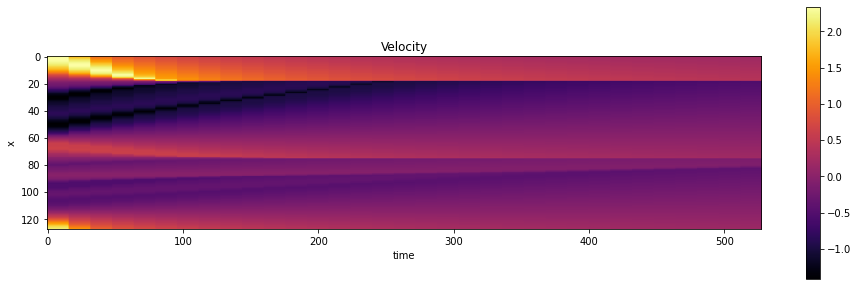

In [36]:
# save for comparison with reconstructions later on 
import os; os.makedirs("./temp",exist_ok=True) 
np.savez_compressed("./temp/burgers-groundtruth-solution.npz", np.reshape(vels_img,[N,STEPS+1])) 
# ˓→remove batch & channel dimension 
show_state(vels_img, "Velocity")